In [1]:
from glob import glob
import baltic as bt
from collections import defaultdict
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import pickle
%matplotlib inline
import random
from pprint import pprint

In [9]:
treefiles = glob('*.nwk')
treefiles.sort(key=lambda x: int(x.split('_')[0]))

def make_bt_tree(treefile):
    t = bt.tree()
    bt.make_tree(open(treefile, 'r').readlines()[0].strip(), t)
    t.treeStats() ## initial traversal, checks for stats
    t.sortBranches() ## traverses tree, sorts branches, draws tree
    return t

trees = { i:make_bt_tree(treefile) for i,treefile in enumerate(treefiles)}


Tree height: 2.498180
Tree length: 14.858826
strictly bifurcating tree

Numbers of objects in tree: 361 (180 nodes and 181 leaves)


Tree height: 0.187245
Tree length: 2.131557
strictly bifurcating tree

Numbers of objects in tree: 361 (180 nodes and 181 leaves)


Tree height: 0.320350
Tree length: 3.813262
strictly bifurcating tree

Numbers of objects in tree: 361 (180 nodes and 181 leaves)


Tree height: 0.593595
Tree length: 3.429537
strictly bifurcating tree

Numbers of objects in tree: 361 (180 nodes and 181 leaves)


Tree height: 0.237358
Tree length: 3.298165
strictly bifurcating tree

Numbers of objects in tree: 361 (180 nodes and 181 leaves)


Tree height: 0.173359
Tree length: 3.243521
strictly bifurcating tree

Numbers of objects in tree: 361 (180 nodes and 181 leaves)


Tree height: 0.281599
Tree length: 3.908525
strictly bifurcating tree

Numbers of objects in tree: 361 (180 nodes and 181 leaves)



In [10]:
def euclidean((x1,y1),(x2,y2)):
    return ((float(x2)-float(x1))**2+(float(y1)-float(y2))**2)**0.5

def sum_tip_distances(tree1,tree2):
    tree1_tips = { k.numName: k for k in tree1.Objects if k.branchType=='leaf' }
    tree2_tips = { k.numName: k for k in tree2.Objects if k.branchType=='leaf' }
    shared_tips = set(tree1_tips.keys()).intersection(set(tree2_tips.keys()))
    total_dist = 0.0
    
    for t in shared_tips:
        total_dist += euclidean( (tree1_tips[t].x, tree1_tips[t].y), (tree2_tips[t].x, tree2_tips[t].y) )
    
    return total_dist

def untangle(tree1, tree2):
    current_distance = sum_tip_distances(tree1, tree2)
    
    for n in sorted(tree2.nodes,key=lambda x: -x.height):
        if n.parent=='Root':
            continue
        n.rotate()
        tree2.drawTree()
        new_distance = sum_tip_distances(tree1, tree2)
        if new_distance <= current_distance:
            current_distance = new_distance
            continue
        else:
            n.rotate()
            tree2.drawTree()
            
for i in range(1,len(trees)):
    untangle(trees[i-1], trees[i])

AttributeError: node instance has no attribute 'rotate'

In [11]:
ntrees = len(trees.keys())


with open("colourdict4.csv") as f:
  hostColors = dict(x.rstrip().split(',', 1) for x in f)


print(hostColors)



print(ntrees)


{'SOI_ASIA': '#ca0020', 'SOI_EUROPE': '#2c7bb6', 'other-LPAI': '#d9d9d9', 'H5-outlier': '#984ea3', 'H5N8clade_2016-17': '#4daf4a', 'H5N6-chinese': '#ff7f00', 'Human-case': '#000000'}
7


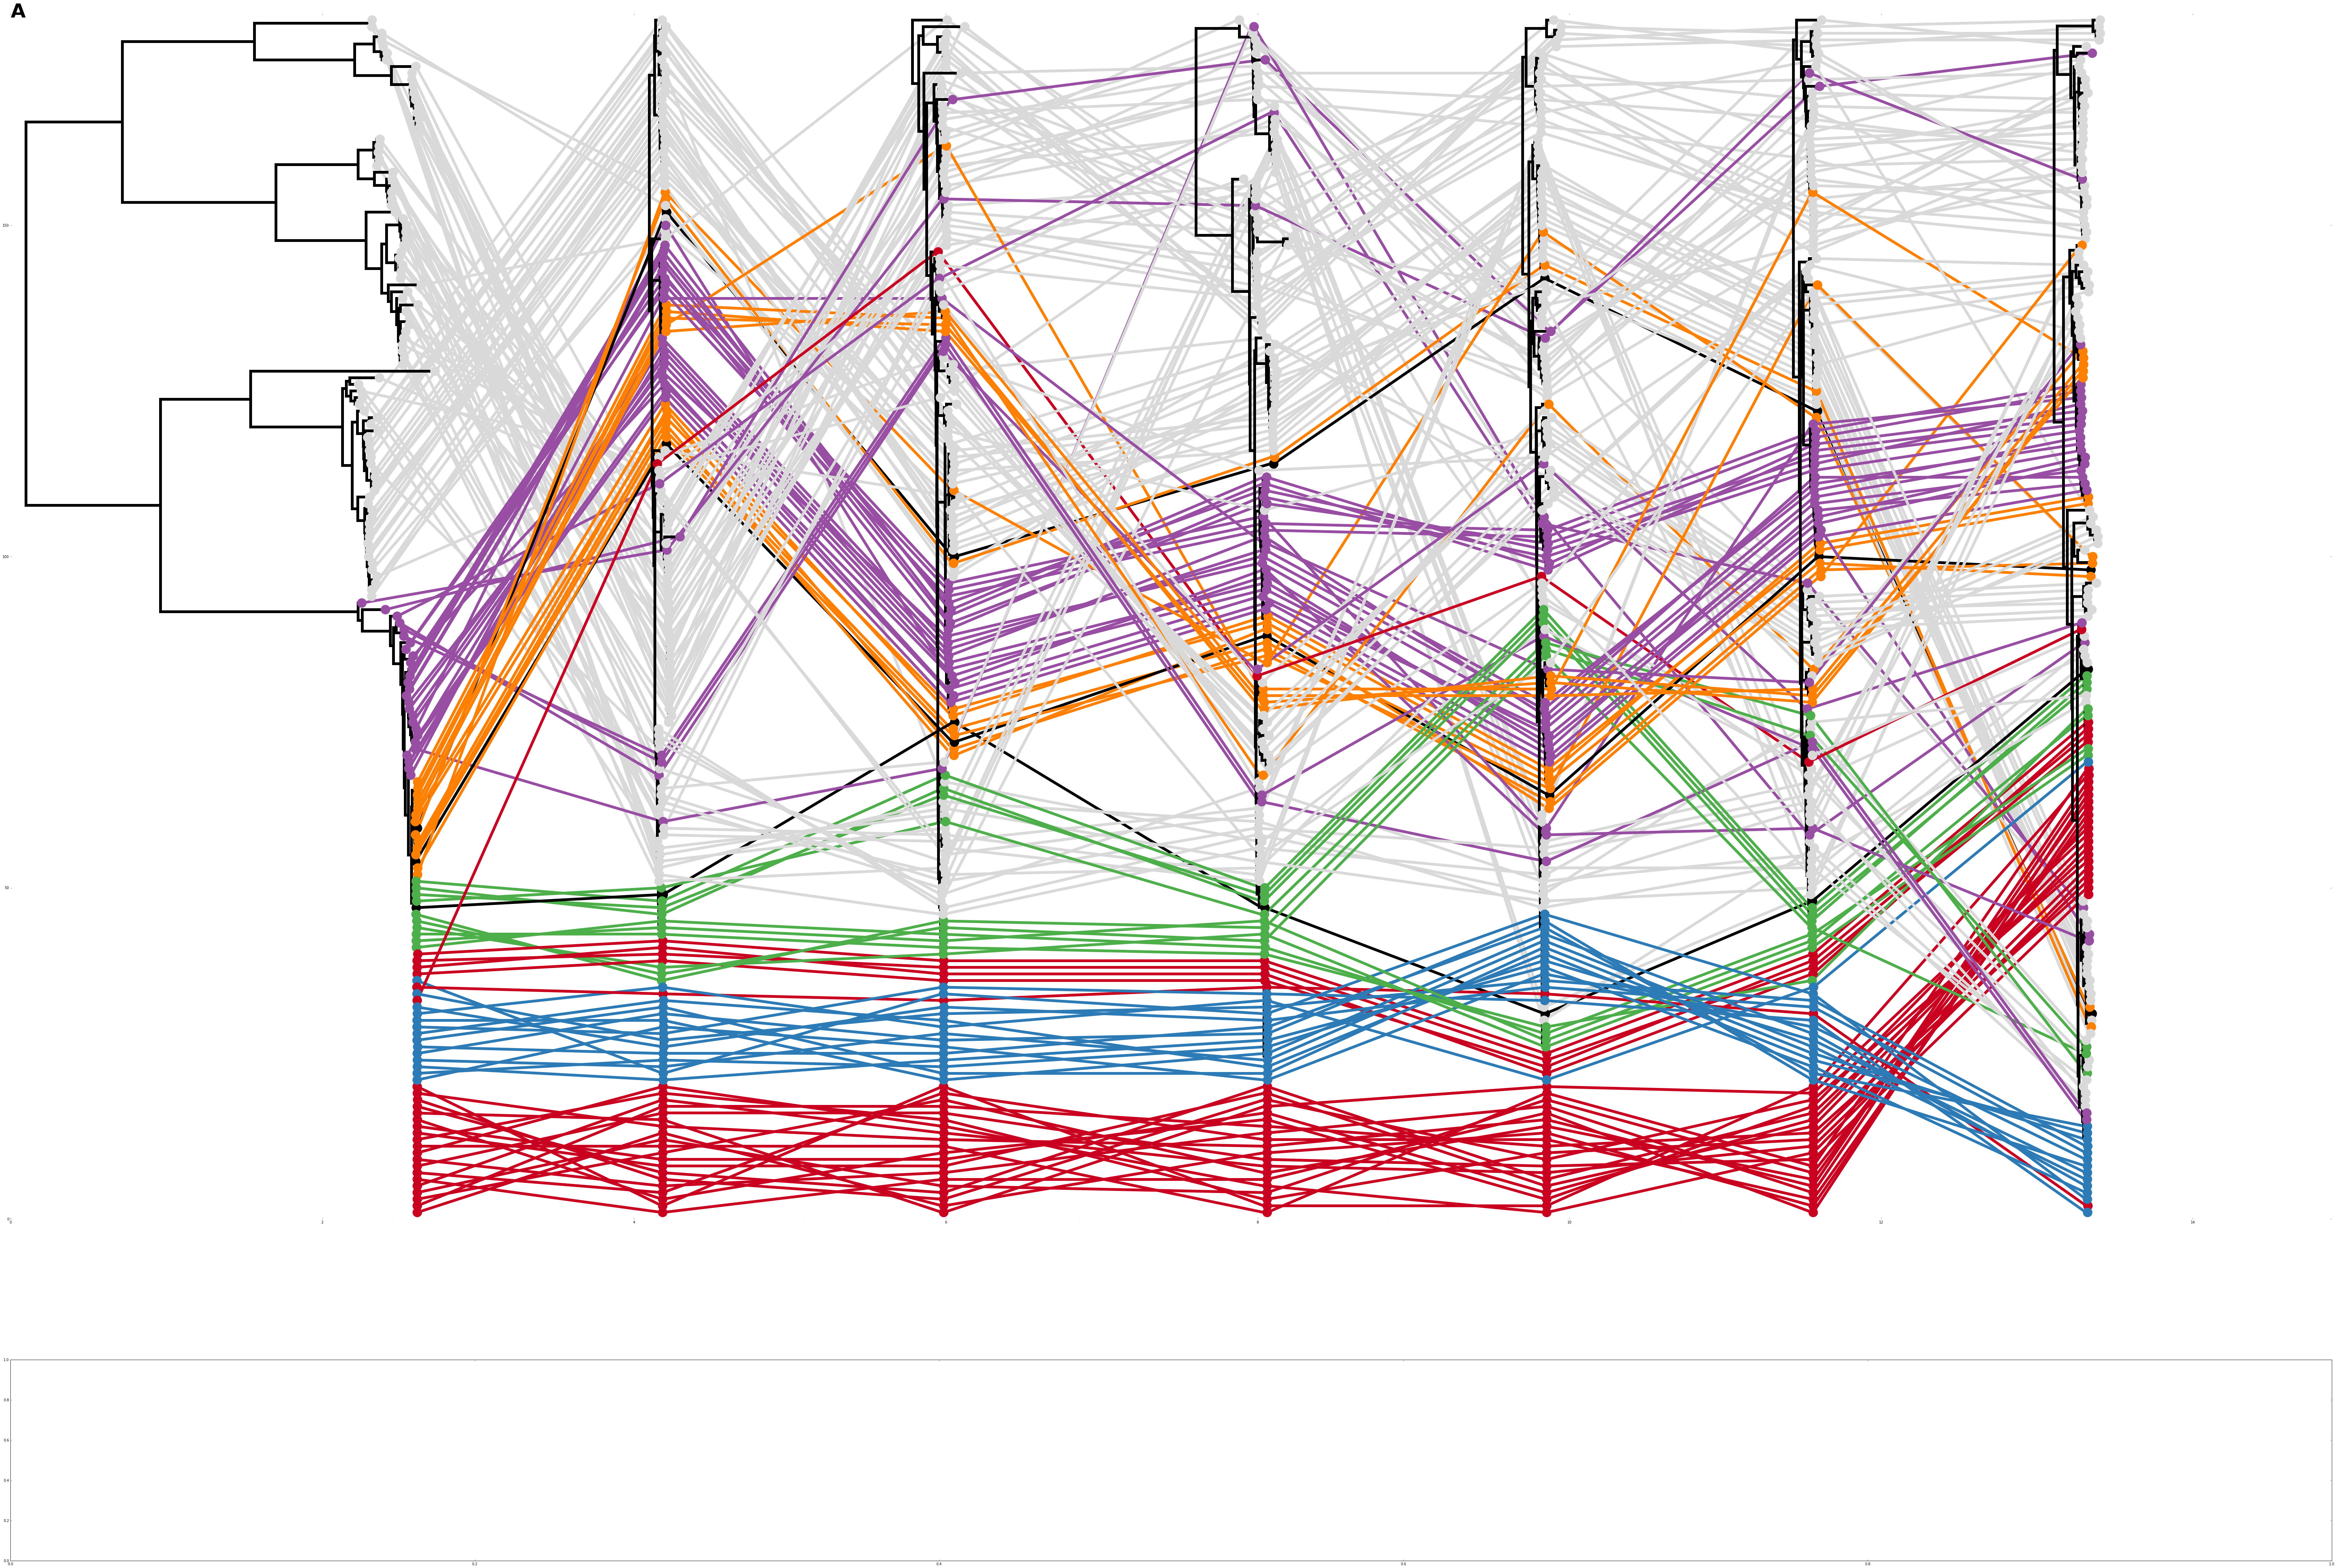

In [12]:

######################
## Plot Trees
#####################
fig, (tr_ax, genome) = plt.subplots(2, figsize=(120,80), gridspec_kw = {'height_ratios':[6.0,1.0]}) #sharex=True)

cumulative_displace=0.1 ## this tracks the "current" x position, so trees are plotted one after another

branchWidth=8 ## increase branch width, since trees will be smaller

tree_names=range(ntrees) ## define order in which dict will be accessed

tip_positions={x:{} for x in tree_names} ## remember the position of each tip in each tree

traitName = 'host'

for tr in tree_names: ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    for k in cur_tree.Objects: ## iterate over branches
        if isinstance(k,bt.leaf): ## only interested in leaves
            k.name = k.numName
            k.traits['host'] = k.name.split('|')[0] # x: int(x.split('_')[-2])
            if k.traits['host'].startswith('H5-out'):
                k.traits['host'] = 'H5-outlier'
            elif k.traits['host'].startswith('H5N6-chin'):
                k.traits['host'] = 'H5N6-chinese'
            elif k.traits['host'].startswith('H5N8clade_'):
                k.traits['host'] = 'H5N8clade_2016-17'
            elif k.traits['host'].startswith('Human-c'):
                k.traits['host'] = 'Human-case'
            elif k.traits['host'].startswith('other-LP'):
                k.traits['host'] = 'other-LPAI'
            elif k.traits['host'].startswith('SOI_AS'):
                k.traits['host'] = 'SOI_ASIA'
            elif k.traits['host'].startswith('SOI_EUR'):
                k.traits['host'] = 'SOI_EUROPE'
            tip_positions[tr][k.name]=(k.height,k.y) ## remember tree, tip's position


frac_pos = 0.0
maxy = 0.0
# cmap = mpl.cm.viridis
for t,tr in enumerate(tree_names): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    
    for k in cur_tree.Objects: ## iterate over branches
    #     x=k.x ## or from x position determined earlier
        x=k.height*1.05 ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
        if y > maxy:
            maxy = y
        
    #     xp=k.parent.x ## get x position of current object's parent
        xp=k.parent.height*1.05 ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
    
        x+=cumulative_displace ## adjust branch position by displacement, which depends on the position of tree in the overall plot
        xp+=cumulative_displace ## same for branch's parent

        if k.traits.has_key(traitName):
            c=hostColors[k.traits[traitName]] ## can be discrete too
        else:
            c='k'
            
        if k.branchType=='leaf': ## if leaf...
            s=750 ## tip size can be fixed

            tr_ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            #tr_ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

            if t+1<len(tree_names) and k.name in tip_positions[0] and k.name in tip_positions[tree_names[t+1]]:
                pos_in_first_tree=tip_positions[0][k.name][1] ## fetch y coordinate of same tip in the first tree
                frac_pos=pos_in_first_tree/float(len(cur_tree.Objects))*2.0 ## normalize coordinate to be within interval [0.0,1.0]

                if t!=len(tree_names)-1: ## as long as we're not at the last tree - connect tips with coloured lines
                    next_x,next_y=tip_positions[tree_names[t+1]][k.name] ## fetch coordinates of same tip in next tree
                    next_x+=cumulative_displace+cur_tree.treeHeight+1.5 ## adjust x coordinate by current displacement and future displacement

                    tr_ax.plot([x,next_x],[y,next_y],lw=8,ls='-',color=c,zorder=0) ## connect current tip with same tip in the next tree
            else:
                pass
            
        elif isinstance(k,bt.node): ## if node...
            tr_ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color='k',ls='-',zorder=9) ## plot vertical bar

        tr_ax.plot([xp,x],[y,y],lw=branchWidth,color='k',ls='-',zorder=9) ## always plot branch

    tr_ax.text(cumulative_displace+((cur_tree.treeHeight+1.5)/1.7), -0.35, '%d'%(t+1), fontsize=0, fontweight='bold')
    cumulative_displace+=cur_tree.treeHeight+1.5 ## increment displacement by the height of the tree

tr_ax.set_ylim(0.0,maxy+1.0) ## set y limits
tr_ax.set_xlim(0.0,cumulative_displace)

tr_ax.spines['top'].set_visible(False)
tr_ax.spines['right'].set_visible(False)
tr_ax.spines['left'].set_visible(False)
tr_ax.spines['bottom'].set_visible(False)

#tr_ax.tick_params(axis='x',labelsize=0,size=0)
#tr_ax.tick_params(axis='y',labelsize=0,size=0)    
 
tr_ax.text(0.0, maxy+0.5, 'A', size=56, fontweight='bold')
# genome.text(0.0, 1.1, 'B', size=56, fontweight='bold')

plt.savefig('./baltic-iqtree.pdf')
plt.show()
